Project Title: Identifying documents related to a COVID-19 medical procedure

References:
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge
https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool
https://www.kaggle.com/maksimeren/covid-19-literature-clustering/
https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
https://medium.com/datalab-log/measuring-the-statistical-similarity-between-two-samples-using-jensen-shannon-and-kullback-leibler-8d05af514b15


3.1 Loading the data

In [1]:
# Load metadata from dataset CORD-19
# (downloaded from Kaggle COVID-19 Open Research Dataset Challenge)
import pandas as pd

root_path = 'data/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, low_memory=False)
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [2]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287405 entries, 0 to 287404
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          287405 non-null  object 
 1   sha               109257 non-null  object 
 2   source_x          287405 non-null  object 
 3   title             287331 non-null  object 
 4   doi               180682 non-null  object 
 5   pmcid             113251 non-null  object 
 6   pubmed_id         157908 non-null  object 
 7   license           287405 non-null  object 
 8   abstract          203996 non-null  object 
 9   publish_time      287260 non-null  object 
 10  authors           277883 non-null  object 
 11  journal           268037 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  91777 non-null   object 
 14  arxiv_id          3761 non-null    object 
 15  pdf_json_files    109257 non-null  object 
 16  pmc_json_files    82

In [3]:
# Fetch all of JSON file path
import glob # finds all the pathnames matching a specified pattern
import json

json_file = glob.glob(f'data/**/*.json', recursive=True)
len(json_file)

198875

In [4]:
# Running whole dataset is not applicable due to memory limit, so we limit to 25% of dataset. 
json_file = json_file[0:50000]
len(json_file)

50000

In [5]:
# Helper function to read JSON file based on json_schema.txt in the dataset
# We only need 'paper_id', 'title', and 'body_text' from JSON file
# Not all the documents have abstract, so we don't consider it

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.title = content['metadata']['title']
            # combine body text in different sections 
            self.body_text = []
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.title}...{self.body_text[:200]}...'
first_row = FileReader(json_file[0])
print(first_row)

PMC7405720: Potential of combating transmission of COVID-19 using novel self-cleaning superhydrophobic surfaces: part II—thermal, chemical, and mechanical durability...COVID-19 can be transmitted through airborne respiratory droplets, ejected as a result of coughing or sneezing through human contact with contaminated surfaces (Yang and Wang 2020; Gralinski and Menac...


In [6]:
# Read the documents into DataFrame that can be used easily
# Combine 'url' in metadata with other necessory information in JSON files

dict_file = {'paper_id': [], 'title': [], 'body_text': [], 'url': []}
for idx, entry in enumerate(json_file):
    if idx % (len(json_file) // 10) == 0:
        print(f'Processing index: {idx} of {len(json_file)}')
    
    content = FileReader(entry)
    dict_file['paper_id'].append(content.paper_id)
    dict_file['title'].append(content.title)
    dict_file['body_text'].append(content.body_text)
    
    # get 'url from metadata information
    meta_data = meta_df.loc[meta_df['title'] == content.title]
    if len(meta_data['url']) == 0:
        dict_file['url'].append('NaN')
    else:
        # if there are multiple url, just take the first one for later use in HTML reference
        if str(meta_data['url'].values[0]).find(';')!= -1:
            url = meta_data['url'].values[0].split(';')[0]
            dict_file['url'].append(url)
        else:
            dict_file['url'].append(meta_data['url'].values[0])

df = pd.DataFrame(dict_file, columns=['paper_id', 'title', 'body_text', 'url'])

Processing index: 0 of 50000
Processing index: 5000 of 50000
Processing index: 10000 of 50000
Processing index: 15000 of 50000
Processing index: 20000 of 50000
Processing index: 25000 of 50000
Processing index: 30000 of 50000
Processing index: 35000 of 50000
Processing index: 40000 of 50000
Processing index: 45000 of 50000


In [7]:
df.head()

,paper_id,title,body_text,url
0,PMC7405720,Potential of combating transmission of COVID-1...,COVID-19 can be transmitted through airborne r...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
1,PMC7463272,Editorial Commentary: It Takes Two to Tango: T...,"Return to sport after meniscal surgery, as aft...",https://www.ncbi.nlm.nih.gov/pubmed/32891247/
2,PMC7091850,The impact of COVID-19 on the provision of don...,The provision of donors for life-saving hemato...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
3,PMC7188043,The Response of the Anesthesia & Analgesia Com...,"Name: Thomas R. Vetter, MD, MPH.\nContribution...",https://www.ncbi.nlm.nih.gov/pubmed/32332295/
4,PMC7478798,Treatment to reduce vascular calcification in ...,It is well recognized that coronary artery cal...,NaN


3.2 Data Pre-processing

In [8]:
# Handle multiple languages. Drop any language that is not English.
# Determine the language of each paper in the dataframe.

from tqdm import tqdm # show progress bar
from langdetect import detect
from langdetect import DetectorFactory

# set seed to enforce consistent results
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for i in tqdm(range(0,len(df))):
    # split by space into list, take the first x index, join with space
    try:
        lang = detect(df.iloc[i]['body_text'])
    except Exception as e:
        lang = "unknown"
        pass 
    languages.append(lang)

100%|██████████| 50000/50000 [20:00<00:00, 41.64it/s]


In [9]:
# Count each language in the dataset
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
print(languages_dict)

Total: 50000

{'lt': 1, 'pt': 6, 'it': 249, 'da': 1, 'en': 48701, 'zh-cn': 10, 'nl': 70, 'es': 167, 'ja': 1, 'so': 2, 'et': 1, 'af': 1, 'no': 49, 'de': 457, 'tl': 1, 'fr': 179, 'sw': 3, 'hu': 1, 'ca': 11, 'unknown': 84, 'pl': 3, 'id': 1, 'sq': 1}


In [10]:
# Drop any language other than English
df['language'] = languages
df = df[df['language'] == 'en'] 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48701 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   48701 non-null  object
 1   title      48701 non-null  object
 2   body_text  48701 non-null  object
 3   url        35146 non-null  object
 4   language   48701 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [14]:
# Reset the index in the RangeIndex rather than Int64Index, which will avoid
# the error that pops up error later in finding related paper step
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48701 entries, 0 to 48700
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           48701 non-null  int64 
 1   paper_id        48701 non-null  object
 2   title           48701 non-null  object
 3   body_text       48701 non-null  object
 4   url             35146 non-null  object
 5   language        48701 non-null  object
 6   processed_text  48701 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.6+ MB


In [15]:
# Clean up the text
import scispacy
import spacy
import en_core_sci_lg  # for processing biomedical, scientific or clinical text

nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 8000000

In [16]:
import re

# Convert the text to lowercase
df['processed_text'] = df['body_text'].map(lambda x: x.lower())

# remove the math packages used in the documents 
df['processed_text'] = [re.sub('\\+\S*\b', '', sent) for sent in df['processed_text']]

# Remove new line characters
df['processed_text'] = [re.sub('\s+', ' ', sent) for sent in df['processed_text']]

In [17]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [18]:
# customized stop word for scientific documents
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table', 'usepackage'
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'ml', 'mg'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

3.3 Vectorization

In [19]:
# Convert a collection of text documents to a matrix of token counts
# Tried TF-IDF, but didn't work out in the later topic modeling step

from sklearn.feature_extraction.text import CountVectorizer

all_texts = df['processed_text']
count_vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
data_vectorized = count_vectorizer.fit_transform(tqdm(all_texts))

100%|██████████| 48701/48701 [19:20<00:00, 41.97it/s]  


In [20]:
data_vectorized.shape

(48701, 451961)

<AxesSubplot:ylabel='word'>

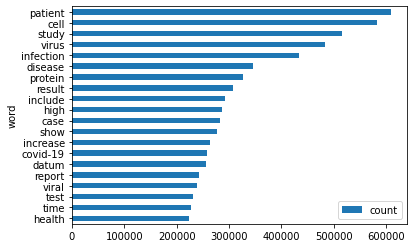

In [21]:
# Most frequent words
import numpy as np

word_count = pd.DataFrame({'word': count_vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [22]:
import joblib # use dump to persist large amount of vectorized data

joblib.dump(count_vectorizer, 'count_vectorizer.csv')
joblib.dump(data_vectorized, 'data_vectorized.csv')

['data_vectorized.csv']

3.4 Topic Modeling

In [23]:
# Use LDA (Latent Dirichlet Allocation) where each document can be described by a 
# distribution of topics and each topic can be described by a distribution of words

from sklearn.decomposition import LatentDirichletAllocation
 
# Reset the number of topics = 50 based on the perplexity value from evaluation in the last
lda_model = LatentDirichletAllocation(n_components=50, random_state=42, n_jobs=-1)
lda_output = lda_model.fit(data_vectorized)
joblib.dump(lda_output, 'lda.csv')

['lda.csv']

In [24]:
# Helper function to print topics to take a look
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [25]:
print_top_words(lda_model, count_vectorizer, n_top_words=25)


Topic #0: ace2 brain increase receptor effect heart rat mouse expression neuron cardiac ii muscle ace study level ang kidney cell function injury animal angiotensin tissue model

Topic #1: cell expression mouse protein level group gene control show increase significantly result induce study usa analysis pathway response effect compare datum treatment infection min apoptosis

Topic #2: air particle temperature concentration study flow water high filter area show aerosol time rate droplet increase condition size system result low environment large exposure pressure

Topic #3: cell infection response mouse immune expression virus cytokine viral cd8 macrophage cd4 type receptor induce infect gene human express study increase show activation antigen production

Topic #4: patient infection pneumonia study antibiotic child isolate bacterial result s. clinical asthma resistance strain group hospital method test antimicrobial treatment culture increase pathogen high bacterium

Topic #5: bind s


Topic #43: protein cell mm antibody bind min buff assay concentration incubate contain ph plate wash add purify μl medium show activity perform result sample pbs solution

Topic #44: food increase activity lockdown obesity consumption sleep author diet india high interest weight journal alcohol research eat meat product physical study exercise report article intake

Topic #45: network model method set cluster datum node dataset algorithm feature base approach result prediction numb different predict image train analysis structure value information identify propose

Topic #46: vaccine vaccination response antigen immune immunization delivery vector protein induce protection immunity antibody adjuvant dna vaccinate development challenge system recombinant high study dose production develope

Topic #47: patient infection surgery treatment risk transplant case diagnosis therapy surgical complication include cause disease recipient acute pneumonia perform cancer transplantation tb symptom 

In [26]:
# Each article is a mixture of topics / a distribution over topics
doc_topic_dist = pd.DataFrame(lda_model.transform(data_vectorized))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)

In [27]:
doc_topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000018,0.000018,0.015816,0.000018,0.000018,0.000018,0.000018,0.000018,0.013102,0.000018,...,0.085247,0.616780,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
1,0.000041,0.000041,0.013539,0.000041,0.000041,0.000041,0.000041,0.000041,0.085792,0.000041,...,0.000041,0.029389,0.170605,0.000041,0.195243,0.000041,0.000041,0.226765,0.000041,0.143520
2,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.409789,0.000091,...,0.091960,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091
3,0.000800,0.000800,0.000800,0.000800,0.171647,0.000800,0.000800,0.000800,0.311416,0.000800,...,0.000800,0.000800,0.000800,0.000800,0.479337,0.000800,0.000800,0.000800,0.000800,0.000800
4,0.101039,0.000010,0.011634,0.000010,0.000010,0.000010,0.000010,0.000010,0.057980,0.000010,...,0.000010,0.000010,0.000010,0.028490,0.023609,0.000010,0.000010,0.000010,0.000010,0.000010


In [ ]:
'''
Tried to visualize the topics, but it runs several hours like forever... 

# Visualize the topics
import pyLDAvis.sklearn

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')
pyLDAvis.display(panel)
'''

3.5 Finding Related Documents

In [28]:
# Check documents to see whether they are related to COVID-19
# Although the dataset is about COVID-19, just assume that this program can be used to other 
# dataset containing documents rather than COVID-19

is_covid19_article = df.body_text.str.contains('covid-19|sars-cov-2|2019-ncov|sars coronavirus 2|2019 novel coronavirus')

In [29]:
# Find k nearest documents by Jensen-Shannon divergence in topic space
# In probability theory and statistics, the Jensen–Shannon divergence is a method of measuring 
# the similarity between two probability distributions.
# https://medium.com/datalab-log/measuring-the-statistical-similarity-between-two-samples-using-jensen-shannon-and-kullback-leibler-8d05af514b15

from scipy.spatial.distance import jensenshannon
import numpy as np

def get_k_nearest_docs(doc_dist, k=5, only_covid19=False, get_dist=False):
    global topic_dist
    
    if only_covid19:
        topic_dist = doc_topic_dist[is_covid19_article][:len(is_covid19_article)]
         
    distances = topic_dist.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

In [30]:
from IPython.display import HTML, display

# Helper function to find related articles, given the text of search content
def relevant_articles(texts, k=10, only_covid19=False):
    text = [texts] if type(texts) is str else texts 
    
    text_vectorized = count_vectorizer.transform(text)
    text_topic_dist = pd.DataFrame(lda_model.transform(text_vectorized))

    for index, bullet in enumerate(text):
        print(bullet)
        recommended, dist = get_k_nearest_docs(text_topic_dist.iloc[index], k, only_covid19, get_dist=True)
        recommended = df.iloc[recommended].copy()
        recommended['similarity'] = 1 - dist
        
    h = '<br/>'.join(['<a href="' + str(l) + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
    display(HTML(h))

In [31]:
from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

# Type in any kind of text (abstract, paragraph, full text, keywords, questions, ...) in the widget 
# and find related articles.
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='70%', height='100px')
    )
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, covidW], layout=Layout(width='70%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, covidW], layout=Layout(width='70%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, covidW.value)

    button.on_click(on_button_clicked)

4. Demonstration

In [32]:
relevant_articles_for_text()

Implementation of diagnostics and products to improve clinical processes


In [33]:
relevant_articles_for_text()

What has been published about medical care


5. Evaluation

The model has been evaluated by changing the number of topics (20, 30, 40, 50) manually in LDA step. The result for different number of topics has been recorded in the project report. When the number of topics is 50, we have higher log likelihood and lower perplexity. Thus, we finally use the model with 50 topics in this project.

In [34]:
# print log-likelihood
print("Log likelihood (50 topics): ", lda_model.score(data_vectorized))

Log likelihood (50 topics):  -703622194.1575209


In [35]:
# print perplexity
print("Perplexity (50 topics): ", lda_model.perplexity(data_vectorized))

Perplexity (50 topics):  2830.663314451241


In [36]:
# Tried GridSearch to find the best LDA model, but it took forever for the large 
# amount of data. In stead, the number of topics were changed manually as above 
# to compare log likelihood and perlexity

''''
Tried GridSearch to find the best LDA model, but it took forever for the large amount of data

# GridSearch the best LDA model with number of topics from 10 to 50.
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [10, 20, 30, 40, 50], 'learning_decay': [.5, .7, .9]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params)

model.fit(data_vectorized)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(data_vectorized))
'''

'\'\nTried GridSearch to find the best LDA model, but it took forever for the large amount of data\n\n# GridSearch the best LDA model with number of topics from 10 to 50.\nfrom sklearn.model_selection import GridSearchCV\n\n# Define Search Param\nsearch_params = {\'n_components\': [10, 20, 30, 40, 50], \'learning_decay\': [.5, .7, .9]}\n\n# Init the model\nlda = LatentDirichletAllocation()\n\n# Init Grid Search class\nmodel = GridSearchCV(lda, search_params)\n\nmodel.fit(data_vectorized)\nbest_lda_model = model.best_estimator_\nprint("Best model\'s params: ", model.best_params_)\nprint("Best log likelihood score: ", model.best_score_)\nprint("Model perplexity: ", best_lda_model.perplexity(data_vectorized))\n'